# Traditional machine learning models for age prediction on EEG data

This notebook uses traditional ML methods to predict the age of infants using EEG data. The EEG data is preprocessed and features are extracted as shown in the notebook 'Deep learning EEG_dataset preprocessing'. 

In [8]:
import sys, os, fnmatch, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load

sys.path.insert(0, os.path.dirname(os.getcwd()))

from config import PATH_MODELS, PATH_DATA_PROCESSED_ML

## Load preprocessed data

Steps:

1. Get all the files in the output folder
2. Get the full paths of the files without the .h5 or .csv extensions
3. Load the features from the .h5 files
4. Assign the proper labels to the files based on the metadata
5. Assign the subject's code to the files based on the metadata
6. Split the data into a training, validation and test set (NOTE: make sure data points from same subjects don't end up in same set

In [9]:
%%time

from sklearn.model_selection import train_test_split

# Step 1: Get all the files in the output folder
file_names = os.listdir(PATH_DATA_PROCESSED_ML)

# Step 2: Get the full paths of the files (without extensions)
files = [os.path.splitext(os.path.join(PATH_DATA_PROCESSED_ML, file_name))[0] for file_name in fnmatch.filter(file_names, "*.h5")]

# Step 3: Load the features
frames = []

for idx, feature_file in enumerate(files):
    df_features = pd.read_hdf(feature_file + ".h5")
    df_metadata = pd.read_csv(feature_file.replace("extracted_features_", "processed_data_") + ".csv")
    
    # Step 4: Assign labels
    df_features['label'] = df_metadata['age_months'][0]
    
    # Step 5: Assign subject code
    df_features['code'] = df_metadata['code'][0]
    frames.append(df_features)

df = pd.concat(frames) 

# Step 6: List all the unique subject IDs
subject_ids = sorted(list(set(df["code"].tolist())))

IDs_train, IDs_temp = train_test_split(subject_ids, test_size=0.3, random_state=42)
IDs_test, IDs_val = train_test_split(IDs_temp, test_size=0.5, random_state=42)

# Step 7: Split the DataFrames into train, validation and test
df_train = df[df['code'].isin(IDs_train)]
df_val = df[df['code'].isin(IDs_val)]
df_test = df[df['code'].isin(IDs_test)]

feature_names = df.columns.values

CPU times: user 37 s, sys: 20.7 s, total: 57.7 s
Wall time: 1min 12s


In [10]:
print(f"Train/val/test proportions: {len(df_train)/len(df)}/{len(df_val)/len(df)}/{len(df_test)/len(df)}")

Train/val/test proportions: 0.699321126227247/0.1559092427564015/0.1447696310163516


In [11]:
%%time

X_train = df_train.drop(['label', 'code'], axis=1).reset_index(drop=True)
y_train = df_train['label'].reset_index(drop=True)
codes_train = df_train['code'].reset_index(drop=True)

X_val = df_val.drop(['label', 'code'], axis=1).reset_index(drop=True)
y_val = df_val['label'].reset_index(drop=True)
codes_val = df_val['code'].reset_index(drop=True)

X_test = df_test.drop(['label', 'code'], axis=1).reset_index(drop=True)
y_test = df_test['label'].reset_index(drop=True)
codes_test = df_test['code'].reset_index(drop=True)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.fit_transform(X_val)
# X_test = scaler.fit_transform(X_test)

# MARK: reducing from 64 bit float to 32 bit float, to reduce memory usage
X_train = pd.DataFrame(scaler.fit_transform(X_train)).astype('float32')
X_val = pd.DataFrame(scaler.fit_transform(X_val)).astype('float32')
X_test = pd.DataFrame(scaler.fit_transform(X_test)).astype('float32')

CPU times: user 19.7 s, sys: 26.4 s, total: 46.2 s
Wall time: 1min 6s


For the ML models, the data set has been split into train and test. Only for the simple feedforward neural network, we've also used a validation set (taken from the train set). The test set remains the same.

In [12]:
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
codes_train_val = pd.concat([codes_train, codes_val])

In [13]:
del(file_names, files, df, frames, df_features, df_metadata, df_train, df_test, df_val, IDs_train, IDs_val, IDs_test, IDs_temp)

In [14]:
print(f"{X_train.memory_usage(deep=True).sum()/1000000000}")
print(f"{y_train.memory_usage(deep=True)/1000000000}")
print(f"{codes_train.memory_usage(deep=True)/1000000000}")
print(f"{X_val.memory_usage(deep=True).sum()/1000000000}")
print(f"{y_val.memory_usage(deep=True)/1000000000}")
print(f"{codes_val.memory_usage(deep=True)/1000000000}")
print(f"{X_train_val.memory_usage(deep=True).sum()/1000000000}")
print(f"{y_train_val.memory_usage(deep=True)/1000000000}")
print(f"{codes_train_val.memory_usage(deep=True)/1000000000}")
print(f"{X_test.memory_usage(deep=True).sum()/1000000000}")
print(f"{y_test.memory_usage(deep=True)/1000000000}")
print(f"{codes_test.memory_usage(deep=True)/1000000000}")

1.722009728
0.007653504
0.007653504
0.383911328
0.0017064
0.0017064
2.115280448
0.018719296
0.018719296
0.356481128
0.001584488
0.001584488


In [15]:
del(X_train, y_train, codes_train, X_val, y_val, codes_val)

In [16]:
from sklearn.utils import shuffle

# Shuffle data before using
X_train_val, y_train_val, codes_train_val = shuffle(X_train_val, y_train_val, codes_train_val, random_state=42)

chunked_X_train = np.array_split(X_train_val, 100)    
chunked_y_train = np.array_split(y_train_val, 100)

In [17]:
chunks_X_train_ten = []
chunks_y_train_ten = []

for i in range(10):
    chunks_X_train_ten.append(chunked_X_train[i])
    chunks_y_train_ten.append(chunked_y_train[i])

chunks_X_train_ten = pd.concat(chunks_X_train_ten)
chunks_y_train_ten = pd.concat(chunks_y_train_ten)

## Dummy regressor

Firstly, we make predictions with dummy regressors as a simple baseline to see whether other models learn "something". From the sklearn docs: "DummyRegressor is a regressor that makes predictions using simple rules. This regressor is useful as a simple baseline to compare with other (real) regressors."

In [18]:
%%time

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_val, y_train_val)

output_file = os.path.join(PATH_MODELS, 'Dummy_mean.joblib')
dump(dummy_regr, output_file)

CPU times: user 4.32 ms, sys: 5.46 ms, total: 9.77 ms
Wall time: 16.8 ms


['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Dummy_mean.joblib']

In [19]:
%%time

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(X_train_val, y_train_val)

output_file = os.path.join(PATH_MODELS, 'Dummy_median.joblib')
dump(dummy_regr, output_file)

CPU times: user 14.8 ms, sys: 2.35 ms, total: 17.2 ms
Wall time: 16.4 ms


['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Dummy_median.joblib']

## Model 1: Random Forest regressor

In [15]:
%%time

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# NOTE: Gridsearch was extended multiple times initial search, therefore the results 
# for max_features = 40, 60, 70, 80, 90, 100, 150, 250, None can be found in 
# "RF_gridsearchX.joblib" files (X = 2, 3, 4, 5)

parameters = { 
              'max_features': ['sqrt', 'log2', 15, 30, 40, 50, 60, 70, 80, 90, 100, 150, 250, None],
              'min_samples_leaf': [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
             }

RF_gridsearch = GridSearchCV(RandomForestRegressor(n_estimators=100, verbose=10, n_jobs=-1), 
                             parameters, verbose=10, n_jobs=1)

RF_gridsearch.fit(X_train_val, y_train_val)

output_file = os.path.join(PATH_MODELS, 'RF_gridsearch5.joblib')
dump(RF_gridsearch, output_file)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


In [16]:
# NOTE: Gridsearch was extended after initial search. 
# Best parameters found, saved in RF_gridsearch5.joblib: {'max_features': 250, 'min_samples_leaf': 10}
RF_gridsearch.best_params_

### Train with best parameters

In [17]:
%%time

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

RF = RandomForestRegressor(n_estimators=100, max_features=250, min_samples_leaf=10, n_jobs=-1)
RF.fit(X_train_val, y_train_val)

output_file = os.path.join(PATH_MODELS, 'RF.joblib')
dump(RF, output_file)

CPU times: user 22h 41min 33s, sys: 4min 33s, total: 22h 46min 6s
Wall time: 3h 20min 3s


['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/RF.joblib']

## Model 2: Linear Support Vector Regressor

There are a lot of training examples in the training set. According to the sklearn docs: "The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to datasets with more than a couple of 10000 samples." 

They recommend using a linear SVR for large data sets. Therefore, let's try this first.

### Randomized search

In [56]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, mean_absolute_error
from scipy.stats import uniform

# Started with large parameter space, decreased the range of parameters and increased training data
# RS with 1/10th of data shows that C = 0.75 performs best and epsilon = 2.5
parameters = {'linearsvr__C': uniform(0.01, 1),
              'linearsvr__epsilon': uniform(0, 6),
}

scorer = make_scorer(mean_absolute_error, greater_is_better=False)

pipe  = make_pipeline(StandardScaler(),
                      LinearSVR(verbose=2, max_iter=50000))

LSVR_randomsearch = RandomizedSearchCV(pipe, parameters, n_iter=100, cv=5, n_jobs=-1, scoring=scorer, verbose=10)
# LSVR_randomsearch.fit(X_train_val, y_train_val)
LSVR_randomsearch.fit(chunks_X_train_ten, chunks_y_train_ten)

output_file = os.path.join(PATH_MODELS, 'LSVR_randomsearch.joblib')
dump(LSVR_randomsearch, output_file)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 49.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 105.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 162.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 225.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 253.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 309.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 354.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 395.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 457.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 496.3min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 531.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 615.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 746.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      |

[LibLinear]CPU times: user 21min 35s, sys: 14.4 s, total: 21min 49s
Wall time: 2d 13h 46min 24s


['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/LSVR_randomsearch.joblib']

In [57]:
cv_DF = pd.DataFrame(LSVR_randomsearch.cv_results_).sort_values('rank_test_score').head(50)

pd.DataFrame(LSVR_randomsearch.cv_results_).sort_values('rank_test_score').head(30)

# Best C: 1.04, epsilon: 1.467

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearsvr__C,param_linearsvr__epsilon,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
96,3177.464216,452.082788,0.444808,0.018944,0.764226,2.48891,"{'linearsvr__C': 0.7642260453180431, 'linearsv...",-7.161411,-7.224742,-7.099525,-7.210047,-7.167436,-7.172632,0.043847,1
80,2234.630326,296.048794,0.438645,0.041782,0.535297,2.29151,"{'linearsvr__C': 0.5352968149458511, 'linearsv...",-7.163190,-7.222583,-7.099409,-7.209798,-7.168248,-7.172646,0.043235,2
90,3295.353606,472.558333,0.438940,0.026664,0.782259,2.50409,"{'linearsvr__C': 0.7822586122239431, 'linearsv...",-7.161370,-7.224970,-7.100791,-7.209813,-7.166827,-7.172754,0.043459,3
14,2848.737587,382.965418,0.453011,0.023476,0.682954,2.51864,"{'linearsvr__C': 0.6829539926610789, 'linearsv...",-7.161623,-7.225482,-7.100168,-7.210214,-7.166608,-7.172819,0.043849,4
98,3291.010470,425.840021,0.358292,0.056290,0.827719,2.39324,"{'linearsvr__C': 0.8277189082141715, 'linearsv...",-7.162343,-7.223583,-7.099666,-7.210081,-7.168476,-7.172830,0.043464,5
95,1954.621778,220.478590,0.340047,0.040003,0.465881,2.17591,"{'linearsvr__C': 0.46588087875474116, 'linears...",-7.163961,-7.222730,-7.099672,-7.210708,-7.167374,-7.172889,0.043325,6
17,1853.198195,208.376182,0.449959,0.033819,0.447986,2.59125,"{'linearsvr__C': 0.4479862958463473, 'linearsv...",-7.162844,-7.224883,-7.100361,-7.209602,-7.166873,-7.172912,0.043471,7
12,2819.043254,368.312883,0.480624,0.040115,0.680134,2.58212,"{'linearsvr__C': 0.6801343864036077, 'linearsv...",-7.162146,-7.226075,-7.100793,-7.209406,-7.167190,-7.173122,0.043607,8
82,1156.689691,159.694629,0.402757,0.050387,0.271371,2.24166,"{'linearsvr__C': 0.2713706113407466, 'linearsv...",-7.165175,-7.222294,-7.099869,-7.210806,-7.168372,-7.173303,0.043103,9
35,2139.718971,234.596312,0.456644,0.012354,0.519117,2.06242,"{'linearsvr__C': 0.5191165015567474, 'linearsv...",-7.163866,-7.222869,-7.100311,-7.211175,-7.169178,-7.173480,0.043185,10


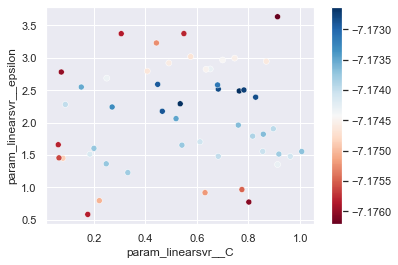

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
ax = sns.scatterplot(x="param_linearsvr__C", y="param_linearsvr__epsilon", hue="mean_test_score", palette='RdBu', data=cv_DF)

norm = plt.Normalize(cv_DF['mean_test_score'].min(), cv_DF['mean_test_score'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()

### Grid search

In [20]:
%%time

from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error

parameters = {'linearsvr__C': [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8],
              'linearsvr__epsilon': [1.5, 2, 2.5, 3],
}

scorer = make_scorer(mean_absolute_error, greater_is_better=False)

pipe  = make_pipeline(StandardScaler(),
                      LinearSVR(verbose=2, max_iter=50000))

LSVR_gridsearch = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1,  scoring=scorer, verbose=10)
# LSVR_gridsearch.fit(X_train_val, y_train_val)
LSVR_gridsearch.fit(chunks_X_train_ten, chunks_y_train_ten)

output_file = os.path.join(PATH_MODELS, 'LSVR_gridsearch.joblib')
dump(LSVR_gridsearch, output_file)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 52.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 87.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 113.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 149.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 187.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 234.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 285.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 348.5min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 410.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 490.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 574.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 674.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | e

[LibLinear]CPU times: user 11min 57s, sys: 5.22 s, total: 12min 2s
Wall time: 12h 32min 54s


['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/LSVR_gridsearch.joblib']

In [21]:
# linearsvr__C': 0.45, 'linearsvr__epsilon': 2.5

LSVR_gridsearch.best_params_

{'linearsvr__C': 0.45, 'linearsvr__epsilon': 2.5}

In [22]:
cv_DF_gs = pd.DataFrame(LSVR_gridsearch.cv_results_).sort_values('rank_test_score').head(50)

pd.DataFrame(LSVR_gridsearch.cv_results_).sort_values('rank_test_score').head(30)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linearsvr__C,param_linearsvr__epsilon,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,1512.205070,201.776546,0.465432,0.043197,0.45,2.5,"{'linearsvr__C': 0.45, 'linearsvr__epsilon': 2.5}",-7.138146,-7.205938,-7.169995,-7.213067,-7.228862,-7.191201,0.032797,1
2,1377.365700,164.921458,0.490647,0.041493,0.4,2.5,"{'linearsvr__C': 0.4, 'linearsvr__epsilon': 2.5}",-7.138531,-7.206086,-7.170030,-7.213294,-7.228552,-7.191299,0.032641,2
4,1403.350965,191.944208,0.424575,0.075168,0.45,1.5,"{'linearsvr__C': 0.45, 'linearsvr__epsilon': 1.5}",-7.137620,-7.207733,-7.172479,-7.211171,-7.228047,-7.191410,0.032407,3
10,1647.424339,200.925310,0.412746,0.080635,0.5,2.5,"{'linearsvr__C': 0.5, 'linearsvr__epsilon': 2.5}",-7.138523,-7.205942,-7.170150,-7.214506,-7.228879,-7.191600,0.032855,4
22,2154.061377,256.453406,0.462474,0.023147,0.65,2.5,"{'linearsvr__C': 0.65, 'linearsvr__epsilon': 2.5}",-7.138152,-7.205639,-7.170646,-7.214685,-7.229211,-7.191667,0.032986,5
26,2295.525338,284.367230,0.486834,0.015941,0.7,2.5,"{'linearsvr__C': 0.7, 'linearsvr__epsilon': 2.5}",-7.138374,-7.206249,-7.170750,-7.214594,-7.228525,-7.191699,0.032785,6
0,1407.405069,195.499220,0.952399,0.076076,0.4,1.5,"{'linearsvr__C': 0.4, 'linearsvr__epsilon': 1.5}",-7.137142,-7.207605,-7.172741,-7.211144,-7.230001,-7.191727,0.032967,7
14,1823.956755,222.283015,0.502755,0.016574,0.55,2.5,"{'linearsvr__C': 0.55, 'linearsvr__epsilon': 2.5}",-7.138601,-7.205783,-7.170167,-7.214603,-7.229579,-7.191746,0.032987,8
28,2208.219988,276.850592,0.435047,0.043581,0.75,1.5,"{'linearsvr__C': 0.75, 'linearsvr__epsilon': 1.5}",-7.138067,-7.207906,-7.172996,-7.211248,-7.228739,-7.191791,0.032382,9
8,1515.341090,198.071302,0.438339,0.045822,0.5,1.5,"{'linearsvr__C': 0.5, 'linearsvr__epsilon': 1.5}",-7.137907,-7.207461,-7.172884,-7.210884,-7.229827,-7.191793,0.032612,10


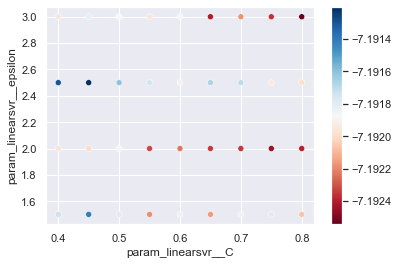

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
ax = sns.scatterplot(x="param_linearsvr__C", y="param_linearsvr__epsilon", hue="mean_test_score", palette='RdBu', data=cv_DF_gs)

norm = plt.Normalize(cv_DF_gs['mean_test_score'].min(), cv_DF_gs['mean_test_score'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()

### Train on all data with best parameters

In [11]:
%%time
# 13h 45m

from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

LSVR  = make_pipeline(StandardScaler(),
                      LinearSVR(verbose=0, C=0.45, epsilon=2.5, max_iter=50000))

LSVR.fit(X_train_val, y_train_val)

output_file = os.path.join(PATH_MODELS, 'LSVR.joblib')
dump(LSVR, output_file)

CPU times: user 2h 42min 10s, sys: 6min 27s, total: 2h 48min 37s
Wall time: 2h 52min 26s


['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/LSVR.joblib']

## Model 3: (Non-linear) Support Vector Regressor

Let's try fitting a SVR on a (small) chunk of the training data. The parameter search below is quite small, but a broader search has been done before. However, a more fine-grained search is still necessary. The downside of SVR with a non-linear kernel is that it's very slow to fit and predict.

### Randomized search

In [39]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from scipy.stats import uniform
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Kernels discarded after initial RandomizedSearch: poly, sigmoid
# parameters = {'svr__C': uniform(0.01, 200),
#               'svr__epsilon': uniform(0, 12),
#               'svr__gamma': uniform(0.0001, 5)
# }

# Initial search with 1/100th: 10<C<30 and 0.5<epsilon<3.5 are good
# parameters = {'svr__C': uniform(0.01, 50),
#               'svr__epsilon': uniform(0, 6),
# }

# Gamma values around gamma='scale' appear to be doing best, so use this.

parameters = {'svr__C': uniform(0.01, 50),
              'svr__epsilon': uniform(0, 6),
              'svr__gamma': uniform(0.00001, 0.01)
}

scorer = make_scorer(mean_absolute_error, greater_is_better=False)

pipe  = make_pipeline(StandardScaler(),
                      SVR(verbose=True))

SVR_randomsearch = RandomizedSearchCV(pipe, parameters, n_iter=100, cv=5, n_jobs=-1, scoring=scorer, verbose=10)
SVR_randomsearch.fit(chunked_X_train[0], chunked_y_train[0])

output_file = os.path.join(PATH_MODELS, 'SVR_randomsearch.joblib')
dump(SVR_randomsearch, output_file)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 45.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 50

[LibSVM]CPU times: user 1min 11s, sys: 1.24 s, total: 1min 13s
Wall time: 2h 24min 15s


['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/SVR_randomsearch.joblib']

In [40]:
SVR_randomsearch.best_params_

# {'svr__C': 21.853178059008552, 'svr__epsilon': 1.9200699291468462} (scale)

{'svr__C': 26.682168877978544,
 'svr__epsilon': 1.8139804396534496,
 'svr__gamma': 0.001285560001035846}

In [70]:
DF_RS_SVR = pd.DataFrame(SVR_randomsearch.cv_results_).sort_values('rank_test_score')

DF_RS_SVR = DF_RS_SVR.loc[DF_RS_SVR['param_svr__gamma'] < 0.0025].head(20)

DF_RS_SVR.head(30)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__epsilon,param_svr__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
78,93.743567,0.433628,24.402092,0.180199,26.6822,1.81398,0.00128556,"{'svr__C': 26.682168877978544, 'svr__epsilon':...",-6.740086,-6.725831,-6.904267,-6.828056,-6.779191,-6.795486,0.064932,1
48,95.850173,2.471275,24.859415,1.995832,29.3393,3.14022,0.00117415,"{'svr__C': 29.339327536970313, 'svr__epsilon':...",-6.735980,-6.743224,-6.920227,-6.860509,-6.808833,-6.813755,0.070100,2
28,81.179342,6.293680,20.246067,2.074093,19.1569,2.71534,0.001352,"{'svr__C': 19.156874086465372, 'svr__epsilon':...",-6.740713,-6.734932,-6.927620,-6.867435,-6.799472,-6.814035,0.074295,3
96,96.442117,0.362438,21.743417,1.106252,49.9665,2.57938,0.000999413,"{'svr__C': 49.96646251919164, 'svr__epsilon': ...",-6.748910,-6.750783,-6.922935,-6.840136,-6.819162,-6.816385,0.064469,5
4,72.522134,0.803965,17.523854,0.039825,29.6666,3.35154,0.00116241,"{'svr__C': 29.666638782582506, 'svr__epsilon':...",-6.738384,-6.747548,-6.924486,-6.864507,-6.813812,-6.817747,0.070458,6
80,72.457859,1.510373,18.245770,2.876327,43.7374,4.82896,0.0015343,"{'svr__C': 43.73743197572619, 'svr__epsilon': ...",-6.746545,-6.763825,-6.893418,-6.835151,-6.860748,-6.819938,0.056270,7
76,86.053352,0.406847,20.169968,0.836795,37.0779,2.85321,0.00236152,"{'svr__C': 37.07787463463881, 'svr__epsilon': ...",-6.749977,-6.732709,-6.886159,-6.852542,-6.883984,-6.821074,0.066403,8
81,89.017143,0.611738,21.713248,2.008235,26.2682,3.69491,0.00135407,"{'svr__C': 26.268172048130893, 'svr__epsilon':...",-6.743545,-6.746309,-6.926743,-6.868791,-6.823311,-6.821740,0.070776,9
61,75.741141,4.731879,17.127447,0.969941,42.9834,4.63294,0.00202936,"{'svr__C': 42.98338334429258, 'svr__epsilon': ...",-6.741724,-6.762339,-6.893745,-6.836858,-6.877155,-6.822364,0.060685,10
43,96.431916,9.505528,31.434437,9.506045,10.6592,1.84769,0.00188061,"{'svr__C': 10.659165680437027, 'svr__epsilon':...",-6.753396,-6.750108,-6.946061,-6.896790,-6.794905,-6.828252,0.079244,11


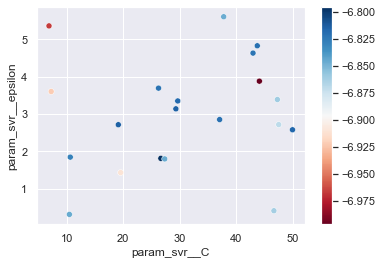

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
ax = sns.scatterplot(x="param_svr__C", y="param_svr__epsilon", hue="mean_test_score", palette='RdBu', data=DF_RS_SVR)

norm = plt.Normalize(DF_RS_SVR['mean_test_score'].min(), DF_RS_SVR['mean_test_score'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()

<AxesSubplot:xlabel='param_svr__gamma', ylabel='mean_test_score'>

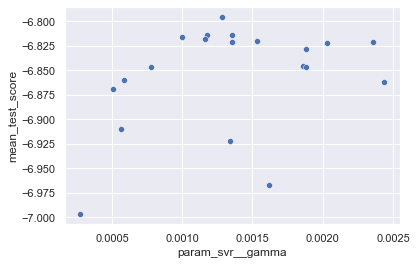

In [72]:
sns.scatterplot(x="param_svr__gamma", y="mean_test_score", data=DF_RS_SVR)

### Grid search

In [24]:
%%time
# 4h 20m

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.preprocessing import StandardScaler

parameters = {'svr__C': [10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50],
              'svr__epsilon': [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5]
}

scorer = make_scorer(mean_absolute_error, greater_is_better=False)

pipe  = make_pipeline(StandardScaler(),
                      SVR(verbose=True, kernel='rbf'))

SVR_gridsearch = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, scoring=scorer, verbose=10)
SVR_gridsearch.fit(chunked_X_train[0], chunked_y_train[0])

output_file = os.path.join(PATH_MODELS, 'SVR_gridsearch.joblib')
dump(SVR_gridsearch, output_file)

Fitting 5 folds for each of 170 candidates, totalling 850 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 39

[LibSVM]CPU times: user 1min 20s, sys: 902 ms, total: 1min 21s
Wall time: 2h 58min 16s


['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/SVR_gridsearch.joblib']

In [25]:
#  'svr__C': 20, 'svr__epsilon': 2
SVR_gridsearch.best_params_

{'svr__C': 20, 'svr__epsilon': 1.5}

In [26]:
DF_GS_SVR = pd.DataFrame(SVR_gridsearch.cv_results_).sort_values('rank_test_score')

pd.DataFrame(SVR_gridsearch.cv_results_).sort_values('rank_test_score').head(30)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svr__C,param_svr__epsilon,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
41,95.228856,0.425107,22.638828,0.252076,20,1.5,"{'svr__C': 20, 'svr__epsilon': 1.5}",-6.753329,-6.725694,-6.698898,-6.705471,-6.783640,-6.733407,0.031467,1
40,100.933807,0.282686,23.555380,0.285569,20,1,"{'svr__C': 20, 'svr__epsilon': 1}",-6.764246,-6.718452,-6.702313,-6.706642,-6.776421,-6.733615,0.030685,2
50,101.298305,0.576302,23.391291,0.430424,22.5,1,"{'svr__C': 22.5, 'svr__epsilon': 1}",-6.763882,-6.722858,-6.697553,-6.709748,-6.775811,-6.733970,0.030600,3
51,95.484877,0.190663,22.570819,0.300935,22.5,1.5,"{'svr__C': 22.5, 'svr__epsilon': 1.5}",-6.754131,-6.729123,-6.695351,-6.709332,-6.784346,-6.734457,0.031828,4
31,94.718327,0.320281,22.763983,0.297555,17.5,1.5,"{'svr__C': 17.5, 'svr__epsilon': 1.5}",-6.757191,-6.724933,-6.705942,-6.703383,-6.787622,-6.735814,0.032260,5
30,100.346868,0.162105,23.800806,0.173280,17.5,1,"{'svr__C': 17.5, 'svr__epsilon': 1}",-6.763684,-6.718123,-6.709727,-6.706242,-6.782519,-6.736059,0.031067,6
61,95.610542,0.252658,22.727466,0.177686,25,1.5,"{'svr__C': 25, 'svr__epsilon': 1.5}",-6.756258,-6.734192,-6.695415,-6.712070,-6.787585,-6.737104,0.032522,7
60,102.039545,0.566738,23.614917,0.290872,25,1,"{'svr__C': 25, 'svr__epsilon': 1}",-6.766792,-6.728147,-6.697046,-6.714297,-6.779899,-6.737236,0.031362,8
42,90.262984,0.467564,21.527054,0.414941,20,2,"{'svr__C': 20, 'svr__epsilon': 2}",-6.745476,-6.735075,-6.699615,-6.710708,-6.795573,-6.737289,0.033451,9
52,90.358599,0.719507,21.469119,0.512413,22.5,2,"{'svr__C': 22.5, 'svr__epsilon': 2}",-6.743219,-6.738391,-6.697802,-6.712067,-6.796886,-6.737673,0.034008,10


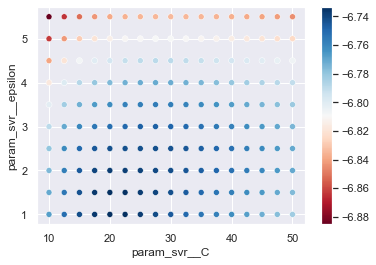

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
ax = sns.scatterplot(x="param_svr__C", y="param_svr__epsilon", hue="mean_test_score", palette='RdBu', data=DF_GS_SVR)

norm = plt.Normalize(DF_GS_SVR['mean_test_score'].min(), DF_GS_SVR['mean_test_score'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()

### Train with best parameters

In [12]:
%%time

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.preprocessing import StandardScaler


SVR  = make_pipeline(StandardScaler(),
                      SVR(C=20, epsilon=1.5, kernel='rbf'))

SVR.fit(chunks_X_train_ten, chunks_y_train_ten)

output_file = os.path.join(PATH_MODELS, 'SVR.joblib')
dump(SVR, output_file)

CPU times: user 13h 53min 12s, sys: 3min 17s, total: 13h 56min 30s
Wall time: 14h 15min 54s


['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/SVR.joblib']

## Model 4: SGD Regressor

Inschatting tijd, mijn computer:
    
- X min voor een SGD (1 configuratie)
- RandomizedSearch: 250 iteraties, 5 folds per iteratie = 1250
- 1250 SGD * X = X uur (Schatting met mijn 1 core)

Memory usage:
- X GB per core?

Fitting a SVR is computationally expensive. Therefore, we try prediction with an SGD Regressor. According to the sklearn documentation, it's best to start with a RandomizedSearchCV to find reasonable hyperparameters. Therefore, we start with this.

### Randomized search

In [50]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, loguniform
from sklearn.metrics import make_scorer, mean_absolute_error


# Loss epsilon insensitive/huber are okay, squared loss/squared epsilon is really bad
# Penalty doesn't really matter, l1 best, L1 ratio can therefore be ignored
# Alpha 0.001-0.003
# Epsilon 2.5-5.0

# specify parameters and distributions to sample from
parameters = {'sgdregressor__loss': ['huber', 'epsilon_insensitive'],
              'sgdregressor__alpha': uniform(0.001, 0.003),
              'sgdregressor__epsilon': uniform(2.5, 5),
             }

scorer = make_scorer(mean_absolute_error, greater_is_better=False)

pipe = make_pipeline(StandardScaler(),
                     SGDRegressor(verbose=10))

SGD_randomsearch = RandomizedSearchCV(pipe, parameters, n_iter=1000, cv=5, n_jobs=-1, scoring=scorer, verbose=10)
SGD_randomsearch.fit(chunked_X_train[0], chunked_y_train[0])

output_file = os.path.join(PATH_MODELS, 'SGD_randomsearch.joblib')
dump(SGD_randomsearch, output_file)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

-- Epoch 1
Norm: 4.67, NNZs: 450, Bias: 25.626126, T: 11700, Avg. loss: 32.323855
Total training time: 0.03 seconds.
-- Epoch 2
Norm: 5.70, NNZs: 450, Bias: 26.708516, T: 23400, Avg. loss: 19.902211
Total training time: 0.06 seconds.
-- Epoch 3
Norm: 6.48, NNZs: 450, Bias: 26.698037, T: 35100, Avg. loss: 19.424926
Total training time: 0.08 seconds.
-- Epoch 4
Norm: 7.00, NNZs: 450, Bias: 26.659366, T: 46800, Avg. loss: 19.211777
Total training time: 0.11 seconds.
-- Epoch 5
Norm: 7.46, NNZs: 450, Bias: 26.690991, T: 58500, Avg. loss: 19.193556
Total training time: 0.14 seconds.
-- Epoch 6
Norm: 7.75, NNZs: 450, Bias: 26.732748, T: 70200, Avg. loss: 19.031230
Total training time: 0.17 seconds.
-- Epoch 7
Norm: 7.99, NNZs: 450, Bias: 26.671086, T: 81900, Avg. loss: 18.962338
Total training time: 0.19 seconds.
-- Epoch 8
Norm: 8.18, NNZs: 450, Bias: 26.748155, T: 93600, Avg. loss: 18.937248
Total training time: 0.22 seconds.
-- Epoch 9
Norm: 8.43, NNZs: 450, Bias: 26.740937, T: 105300, Av

['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/SGD_randomsearch.joblib']

In [51]:
SGD_randomsearch.best_params_


{'sgdregressor__alpha': 0.0034877449170399345,
 'sgdregressor__epsilon': 3.281812397148754,
 'sgdregressor__loss': 'huber'}

In [55]:
DF_RS_SGD = pd.DataFrame(SGD_randomsearch.cv_results_).sort_values('rank_test_score')

DF_RS_SGD = DF_RS_SGD.loc[DF_RS_SGD['param_sgdregressor__loss'] == 'huber'].sort_values('rank_test_score').head(5000)
DF_RS_SGD.head(60)
# DF_RS_SGD.head(1000)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdregressor__alpha,param_sgdregressor__epsilon,param_sgdregressor__loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
778,1.830280,0.343348,0.057382,0.005132,0.00348774,3.28181,huber,"{'sgdregressor__alpha': 0.0034877449170399345,...",-7.535427,-7.260982,-7.478827,-7.239829,-7.402024,-7.383418,0.116760,1
752,2.245172,0.447945,0.047721,0.006135,0.00355382,2.95462,huber,"{'sgdregressor__alpha': 0.003553817701427189, ...",-7.493340,-7.266673,-7.524510,-7.235042,-7.414868,-7.386887,0.117101,2
145,1.825085,0.499419,0.053225,0.005582,0.00298465,2.53614,huber,"{'sgdregressor__alpha': 0.00298464703049976, '...",-7.511085,-7.279271,-7.484221,-7.251543,-7.416710,-7.388566,0.105521,3
472,2.137682,0.313836,0.046330,0.012236,0.00158251,2.53429,huber,"{'sgdregressor__alpha': 0.0015825118711963802,...",-7.484196,-7.280824,-7.481237,-7.241848,-7.470007,-7.391622,0.107195,4
644,3.333361,0.958534,0.078070,0.023091,0.00252471,3.22644,huber,"{'sgdregressor__alpha': 0.002524714746107364, ...",-7.497736,-7.276400,-7.529979,-7.253706,-7.403282,-7.392221,0.112102,5
0,1.717825,0.243001,0.041453,0.007093,0.00157476,4.1939,huber,"{'sgdregressor__alpha': 0.0015747588885655184,...",-7.517685,-7.290006,-7.509668,-7.278888,-7.387956,-7.396840,0.102702,6
329,1.742813,0.344880,0.049911,0.010300,0.00286566,2.68841,huber,"{'sgdregressor__alpha': 0.0028656561609646226,...",-7.565548,-7.247361,-7.490772,-7.254564,-7.434408,-7.398531,0.127491,7
447,1.792749,0.421049,0.047612,0.008506,0.00348955,5.3531,huber,"{'sgdregressor__alpha': 0.003489550042080718, ...",-7.543159,-7.293696,-7.447182,-7.240302,-7.479719,-7.400812,0.114784,8
725,1.859670,0.619692,0.059108,0.015536,0.00379179,4.32285,huber,"{'sgdregressor__alpha': 0.003791788059993999, ...",-7.534521,-7.284969,-7.529547,-7.223085,-7.435376,-7.401499,0.127004,9
23,1.235684,0.073202,0.039372,0.006829,0.00398348,2.77423,huber,"{'sgdregressor__alpha': 0.00398348316831062, '...",-7.539740,-7.277230,-7.462259,-7.298641,-7.434403,-7.402455,0.099903,10


<AxesSubplot:xlabel='param_sgdregressor__alpha', ylabel='mean_test_score'>

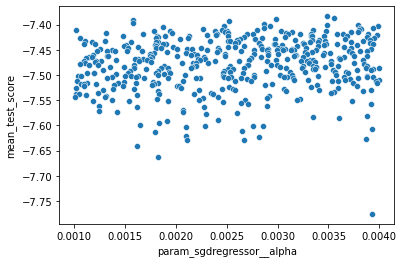

In [58]:
import seaborn as sns

sns.scatterplot(x="param_sgdregressor__alpha", y="mean_test_score", data=DF_RS_SGD)

### Grid search

In [57]:
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, loguniform
from sklearn.metrics import make_scorer, mean_absolute_error

parameters = {'sgdregressor__loss': ['huber', 'epsilon_insensitive'],
              'sgdregressor__alpha': [0.0010, 0.0015, 0.0020, 0.0025, 0.0030],
              'sgdregressor__epsilon': [2.5, 3, 3.5, 4, 4.5, 5],
             }

scorer = make_scorer(mean_absolute_error, greater_is_better=False)

pipe = make_pipeline(StandardScaler(),
                     SGDRegressor(verbose=10))

SGD_gridsearch = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, scoring=scorer, verbose=10)
SGD_gridsearch.fit(chunks_X_train_ten, chunks_y_train_ten)

output_file = os.path.join(PATH_MODELS, 'SGD_gridsearch.joblib')
dump(SGD_gridsearch, output_file)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6

-- Epoch 1
Norm: 5.22, NNZs: 450, Bias: 26.298885, T: 117000, Avg. loss: 6.730109
Total training time: 0.18 seconds.
-- Epoch 2
Norm: 6.25, NNZs: 450, Bias: 26.457959, T: 234000, Avg. loss: 5.034392
Total training time: 0.36 seconds.
-- Epoch 3
Norm: 6.83, NNZs: 450, Bias: 26.363235, T: 351000, Avg. loss: 4.996300
Total training time: 0.54 seconds.
-- Epoch 4
Norm: 7.16, NNZs: 450, Bias: 26.405349, T: 468000, Avg. loss: 4.980011
Total training time: 0.73 seconds.
-- Epoch 5
Norm: 7.39, NNZs: 450, Bias: 26.386259, T: 585000, Avg. loss: 4.971060
Total training time: 0.90 seconds.
-- Epoch 6
Norm: 7.59, NNZs: 450, Bias: 26.410037, T: 702000, Avg. loss: 4.964169
Total training time: 1.08 seconds.
-- Epoch 7
Norm: 7.70, NNZs: 450, Bias: 26.396283, T: 819000, Avg. loss: 4.963091
Total training time: 1.26 seconds.
-- Epoch 8
Norm: 7.86, NNZs: 450, Bias: 26.466796, T: 936000, Avg. loss: 4.956198
Total training time: 1.43 seconds.
-- Epoch 9
Norm: 7.94, NNZs: 450, Bias: 26.415064, T: 1053000, A

['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/SGD_gridsearch.joblib']

In [59]:
SGD_gridsearch.best_params_

{'sgdregressor__alpha': 0.001,
 'sgdregressor__epsilon': 2.5,
 'sgdregressor__loss': 'epsilon_insensitive'}

In [65]:
DF_GS_SGD = pd.DataFrame(SGD_gridsearch.cv_results_).sort_values('rank_test_score')
DF_GS_SGD.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdregressor__alpha,param_sgdregressor__epsilon,param_sgdregressor__loss,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,16.098727,1.699272,0.382333,0.054741,0.001,2.5,epsilon_insensitive,"{'sgdregressor__alpha': 0.001, 'sgdregressor__...",-7.165722,-7.230710,-7.185570,-7.226569,-7.236385,-7.208991,0.028114,1
25,12.761213,2.046205,0.321281,0.009427,0.002,2.5,epsilon_insensitive,"{'sgdregressor__alpha': 0.002, 'sgdregressor__...",-7.158357,-7.235667,-7.192042,-7.224234,-7.260303,-7.214121,0.035486,2
5,14.174507,2.408377,0.369663,0.024613,0.001,3.5,epsilon_insensitive,"{'sgdregressor__alpha': 0.001, 'sgdregressor__...",-7.177664,-7.226667,-7.199473,-7.219871,-7.251301,-7.214995,0.024951,3
7,14.445547,0.841378,0.359106,0.029369,0.001,4,epsilon_insensitive,"{'sgdregressor__alpha': 0.001, 'sgdregressor__...",-7.159827,-7.257267,-7.188966,-7.227532,-7.244802,-7.215679,0.036197,4
27,11.911145,0.936309,0.321709,0.024187,0.002,3,epsilon_insensitive,"{'sgdregressor__alpha': 0.002, 'sgdregressor__...",-7.156041,-7.243266,-7.185171,-7.257981,-7.244610,-7.217414,0.039648,5


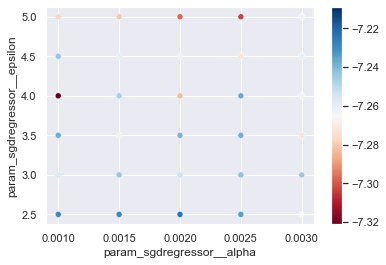

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
ax = sns.scatterplot(x="param_sgdregressor__alpha", y="param_sgdregressor__epsilon", hue="mean_test_score", palette='RdBu', data=DF_GS_SGD)

norm = plt.Normalize(DF_GS_SGD['mean_test_score'].min(), DF_GS_SGD['mean_test_score'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

plt.show()

### Train with best parameters

In [68]:
%%time

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

SGD = make_pipeline(StandardScaler(),
                    SGDRegressor(alpha=0.001, epsilon=2.5, loss='epsilon_insensitive'))

SGD.fit(X_train_val, y_train_val)

output_file = os.path.join(PATH_MODELS, 'SGD.joblib')
dump(SGD, output_file)

CPU times: user 36.1 s, sys: 17.6 s, total: 53.7 s
Wall time: 1min 5s


['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/SGD.joblib']

## Model 5: Relevance Vector Regression

An alternative to the SVR is the Relevance Vector Machine, also used by Vandenbosch (2018). This isn't included in sklearn, but there are two packages called 'scikit-rvm' and 'sklearn-rvm' using the sklearn API that has implemented this.

### Randomized search

Inschatting tijd, mijn computer:
    
- 4 min voor een RVR (1 configuratie)
- RandomizedSearch: 250 iteraties, 5 folds per iteratie = 1250
- 1250 RVR * 4 min = 84 uur (Schatting met mijn 2 cores)

Memory usage:
- 4 GB per core?

In [72]:
%%time

from sklearn_rvm import EMRVR

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error

parameters = {'emrvr__kernel': ['poly', 'rbf', 'sigmoid'],
              'emrvr__degree': [3, 4, 5, 6, 7],
              'emrvr__epsilon': uniform(0, 6),
              'emrvr__gamma': uniform(0.00001, 0.01)
}

scorer = make_scorer(mean_absolute_error, greater_is_better=False)
pipe  = make_pipeline(StandardScaler(),
                      EMRVR(verbose=True, max_iter=50000))

RVR_randomsearch = RandomizedSearchCV(pipe, parameters, n_iter=100, 
                                      cv=5, n_jobs=2, scoring=scorer, verbose=10)
RVR_randomsearch.fit(chunked_X_train[0], chunked_y_train[0])

output_file = os.path.join(PATH_MODELS, 'RVR_randomsearch.joblib')
dump(RVR_randomsearch, output_file)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed: 102.0min
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed: 102.0min
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed: 102.0min
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed: 102.0min


KeyboardInterrupt: 

In [ ]:
RVR_randomsearch.best_params_

### Train on best SVR parameters

In [ ]:
%%time

from sklearn_rvm import EMRVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

EMRVR = make_pipeline(StandardScaler(),
                      EMRVR(kernel='rbf', epsilon=1.5, gamma=(1/450)))

EMRVR.fit(X_train_val, y_train_val)

output_file = os.path.join(PATH_MODELS, 'EMRVR.joblib')
dump(EMRVR, output_file)

### Grid search

Inschatting tijd, mijn computer: 

- 4 min voor 1 RVR (1 configuratie). 
- GridSearch: 50 configuraties, 5 folds per configuratie = 250
- 250 RVR * 4 min = 17 uur (Schatting met mijn 2 cores)

In [ ]:
from sklearn_rvm import EMRVR

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

parameters = {'svr__epsilon': [4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8],
              'svr__gamma': ['scale', 'auto', 0.0015]
}

pipe  = make_pipeline(StandardScaler(),
                      SVR(verbose=True, kernel='rbf'))

RVR_gridsearch = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=10)

RVR_gridsearch.fit(chunked_X_train[0], chunked_y_train[0])

output_file = os.path.join(PATH_MODELS, 'RVR_gridsearch.joblib')
dump(RVR_gridsearch, output_file)

In [ ]:
RVR_gridsearch.best_params_

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

try:
    RVR_gridsearch
except:
    RVR_gridsearch = load(os.path.join(PATH_MODELS, 'RVR_gridsearch.joblib'))    

# Update verbosity
RVR_gridsearch.verbose = 0

# R2
score = RVR_gridsearch.score(X_test, y_test)

# MSE
predictions = RVR_gridsearch.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of Relevance Vector Regressor: R-squared = {score}, RMSE = {rmse} and MAE = {mae}.")

del(rvr_reg)

Performance of Relevance Vector Regressor: R-squared = 0.2122374046333777, RMSE = 10.04744774121648 and MAE = 7.978889908077722.


## Model 6: Neural network

In [40]:
X_train.shape

(956672, 450)

### Helper functions

In [41]:
def plot_loss(history):
    """ Plots the MSE, RMSE, and MAE loss for the training and validation data over time """
    
    %matplotlib inline
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12,12), dpi=200)

    ax1.plot(history.history['loss'], label='training data')  
    min_loss = min(history.history['val_loss'])
    val_plot1 = ax1.plot(history.history['val_loss'], label='validation data')
    ax1.axhline(y = min_loss, color = val_plot1[0].get_color(), linestyle = '--') 
    x0,x1 = ax1.get_xlim()
    ax1.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax1.set_title('MSE loss')
    ax1.set_ylabel("MSE")
    ax1.set_xlabel("epochs")
    ax1.legend()

    ax2.plot(history.history['root_mean_squared_error'], label='training data')
    min_loss = min(history.history['val_root_mean_squared_error'])
    val_plot2 = ax2.plot(history.history['val_root_mean_squared_error'], label='validation data')
    ax2.axhline(y = min_loss, color = val_plot2[0].get_color(), linestyle = '--') 
    x0,x1 = ax2.get_xlim()
    ax2.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax2.set_title('RMSE loss')
    ax2.set_ylabel("RMSE")
    ax2.set_xlabel("epochs")
    ax2.legend()
    
    ax3.plot(history.history['mean_absolute_error'], label='training data')    
    min_loss = min(history.history['val_mean_absolute_error'])
    val_plot3 = ax3.plot(history.history['val_mean_absolute_error'], label='validation data')
    ax3.axhline(y = min_loss, color = val_plot3[0].get_color(), linestyle = '--') 
    x0,x1 = ax3.get_xlim()
    ax3.text(x1, min_loss, "{:.2f}".format(min_loss), ha='left', va='center')
    ax3.set_title('MAE loss')
    ax3.set_ylabel("MAE")
    ax3.set_xlabel("epochs")
    ax3.legend()

In [42]:
input_shape=(450, )

### 'FC_regressor_01'

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def fully_connected_model():
    model = keras.Sequential()
    
    model.add(Dense(512, activation='tanh', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
        
    model.add(Dense(128, activation='tanh'))
    model.add(BatchNormalization())

    model.add(Dense(1))
    
    return model

### 'FC_regressor_02'

In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def fully_connected_model():
    model = keras.Sequential()
    
    model.add(Dense(512, activation='tanh', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
        
    model.add(Dense(128, activation='tanh'))
    model.add(BatchNormalization())

    model.add(Dense(1))
    
    return model

### 'FC_regressor_03'

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def fully_connected_model():
    model = keras.Sequential()
    
    model.add(Dense(300, activation='tanh', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
        
    model.add(Dense(200, activation='tanh'))
    model.add(BatchNormalization())

    model.add(Dense(1))
    
    return model

### 'FC_regressor_04'

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def fully_connected_model():
    model = keras.Sequential()
    
    model.add(Dense(512, activation='tanh', input_shape=input_shape))
    model.add(BatchNormalization())
        
    model.add(Dense(128, activation='tanh'))
    model.add(BatchNormalization())

    model.add(Dense(1))
    
    return model

### 'FC_regressor_05'

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def fully_connected_model():
    model = keras.Sequential()
    
    model.add(Dense(512, activation='tanh', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
        
    model.add(Dense(256, activation='tanh', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(128, activation='tanh'))
    model.add(BatchNormalization())

    model.add(Dense(1))
    
    return model

In [53]:
model = fully_connected_model()

optimizer = Adam(learning_rate=0.01, 
                 beta_1=0.9, 
                 beta_2=0.999, 
                 epsilon=1e-07, 
                 amsgrad=False,
                 name='Adam')

model.build(input_shape)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               230912    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 299,265
Trainable params: 297,985
Non-trainable params: 1,280
____________________________________________

In [54]:
output_filename = 'FC_regressor_01' # MARK: Make sure to update
output_file = os.path.join(PATH_MODELS, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=100, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, min_lr=0.0001, verbose=1)

In [55]:
epochs = 1500

# fit network
history = model.fit(x=X_train,
                    y=y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    callbacks = [checkpointer, earlystopper, reduce_lr])

Epoch 1/1500
29896/29896 [==============================] - 84s 3ms/step - loss: 88.2964 - root_mean_squared_error: 9.3456 - mean_absolute_error: 7.7041 - val_loss: 80.3377 - val_root_mean_squared_error: 8.9631 - val_mean_absolute_error: 7.3992

Epoch 00001: val_loss improved from inf to 80.33772, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/FC_regressor_01.hdf5
Epoch 2/1500
29896/29896 [==============================] - 77s 3ms/step - loss: 81.1971 - root_mean_squared_error: 9.0109 - mean_absolute_error: 7.4715 - val_loss: 79.7002 - val_root_mean_squared_error: 8.9275 - val_mean_absolute_error: 7.3950

Epoch 00002: val_loss improved from 80.33772 to 79.70021, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/FC_regressor_01.hdf5
Epoch 3/1500
29896/29896 [==============================] - 76s 3ms/step - loss: 81.4796 - root_mean_squared_error: 9.0266 - mean_absolute_error: 7.4938 - val_loss: 77.9408 

29896/29896 [==============================] - 101s 3ms/step - loss: 83.2464 - root_mean_squared_error: 9.1239 - mean_absolute_error: 7.5920 - val_loss: 80.6310 - val_root_mean_squared_error: 8.9795 - val_mean_absolute_error: 7.5015

Epoch 00053: val_loss did not improve from 77.25674
Epoch 54/1500
29896/29896 [==============================] - 89s 3ms/step - loss: 83.1596 - root_mean_squared_error: 9.1192 - mean_absolute_error: 7.5907 - val_loss: 80.3650 - val_root_mean_squared_error: 8.9647 - val_mean_absolute_error: 7.5072

Epoch 00054: val_loss did not improve from 77.25674
Epoch 55/1500
29896/29896 [==============================] - 76s 3ms/step - loss: 83.2946 - root_mean_squared_error: 9.1266 - mean_absolute_error: 7.5949 - val_loss: 80.1143 - val_root_mean_squared_error: 8.9507 - val_mean_absolute_error: 7.4948

Epoch 00055: val_loss did not improve from 77.25674
Epoch 56/1500
29896/29896 [==============================] - 79s 3ms/step - loss: 83.5293 - root_mean_squared_error:

29896/29896 [==============================] - 61s 2ms/step - loss: 81.6369 - root_mean_squared_error: 9.0353 - mean_absolute_error: 7.5143 - val_loss: 78.5993 - val_root_mean_squared_error: 8.8656 - val_mean_absolute_error: 7.4171

Epoch 00107: val_loss did not improve from 77.25674
Epoch 108/1500
29896/29896 [==============================] - 61s 2ms/step - loss: 81.4086 - root_mean_squared_error: 9.0226 - mean_absolute_error: 7.5012 - val_loss: 78.6888 - val_root_mean_squared_error: 8.8707 - val_mean_absolute_error: 7.4178

Epoch 00108: val_loss did not improve from 77.25674
Epoch 109/1500
29896/29896 [==============================] - 64s 2ms/step - loss: 81.4018 - root_mean_squared_error: 9.0223 - mean_absolute_error: 7.5012 - val_loss: 79.0155 - val_root_mean_squared_error: 8.8891 - val_mean_absolute_error: 7.4003

Epoch 00109: val_loss did not improve from 77.25674
Epoch 110/1500
29896/29896 [==============================] - 62s 2ms/step - loss: 81.4988 - root_mean_squared_erro

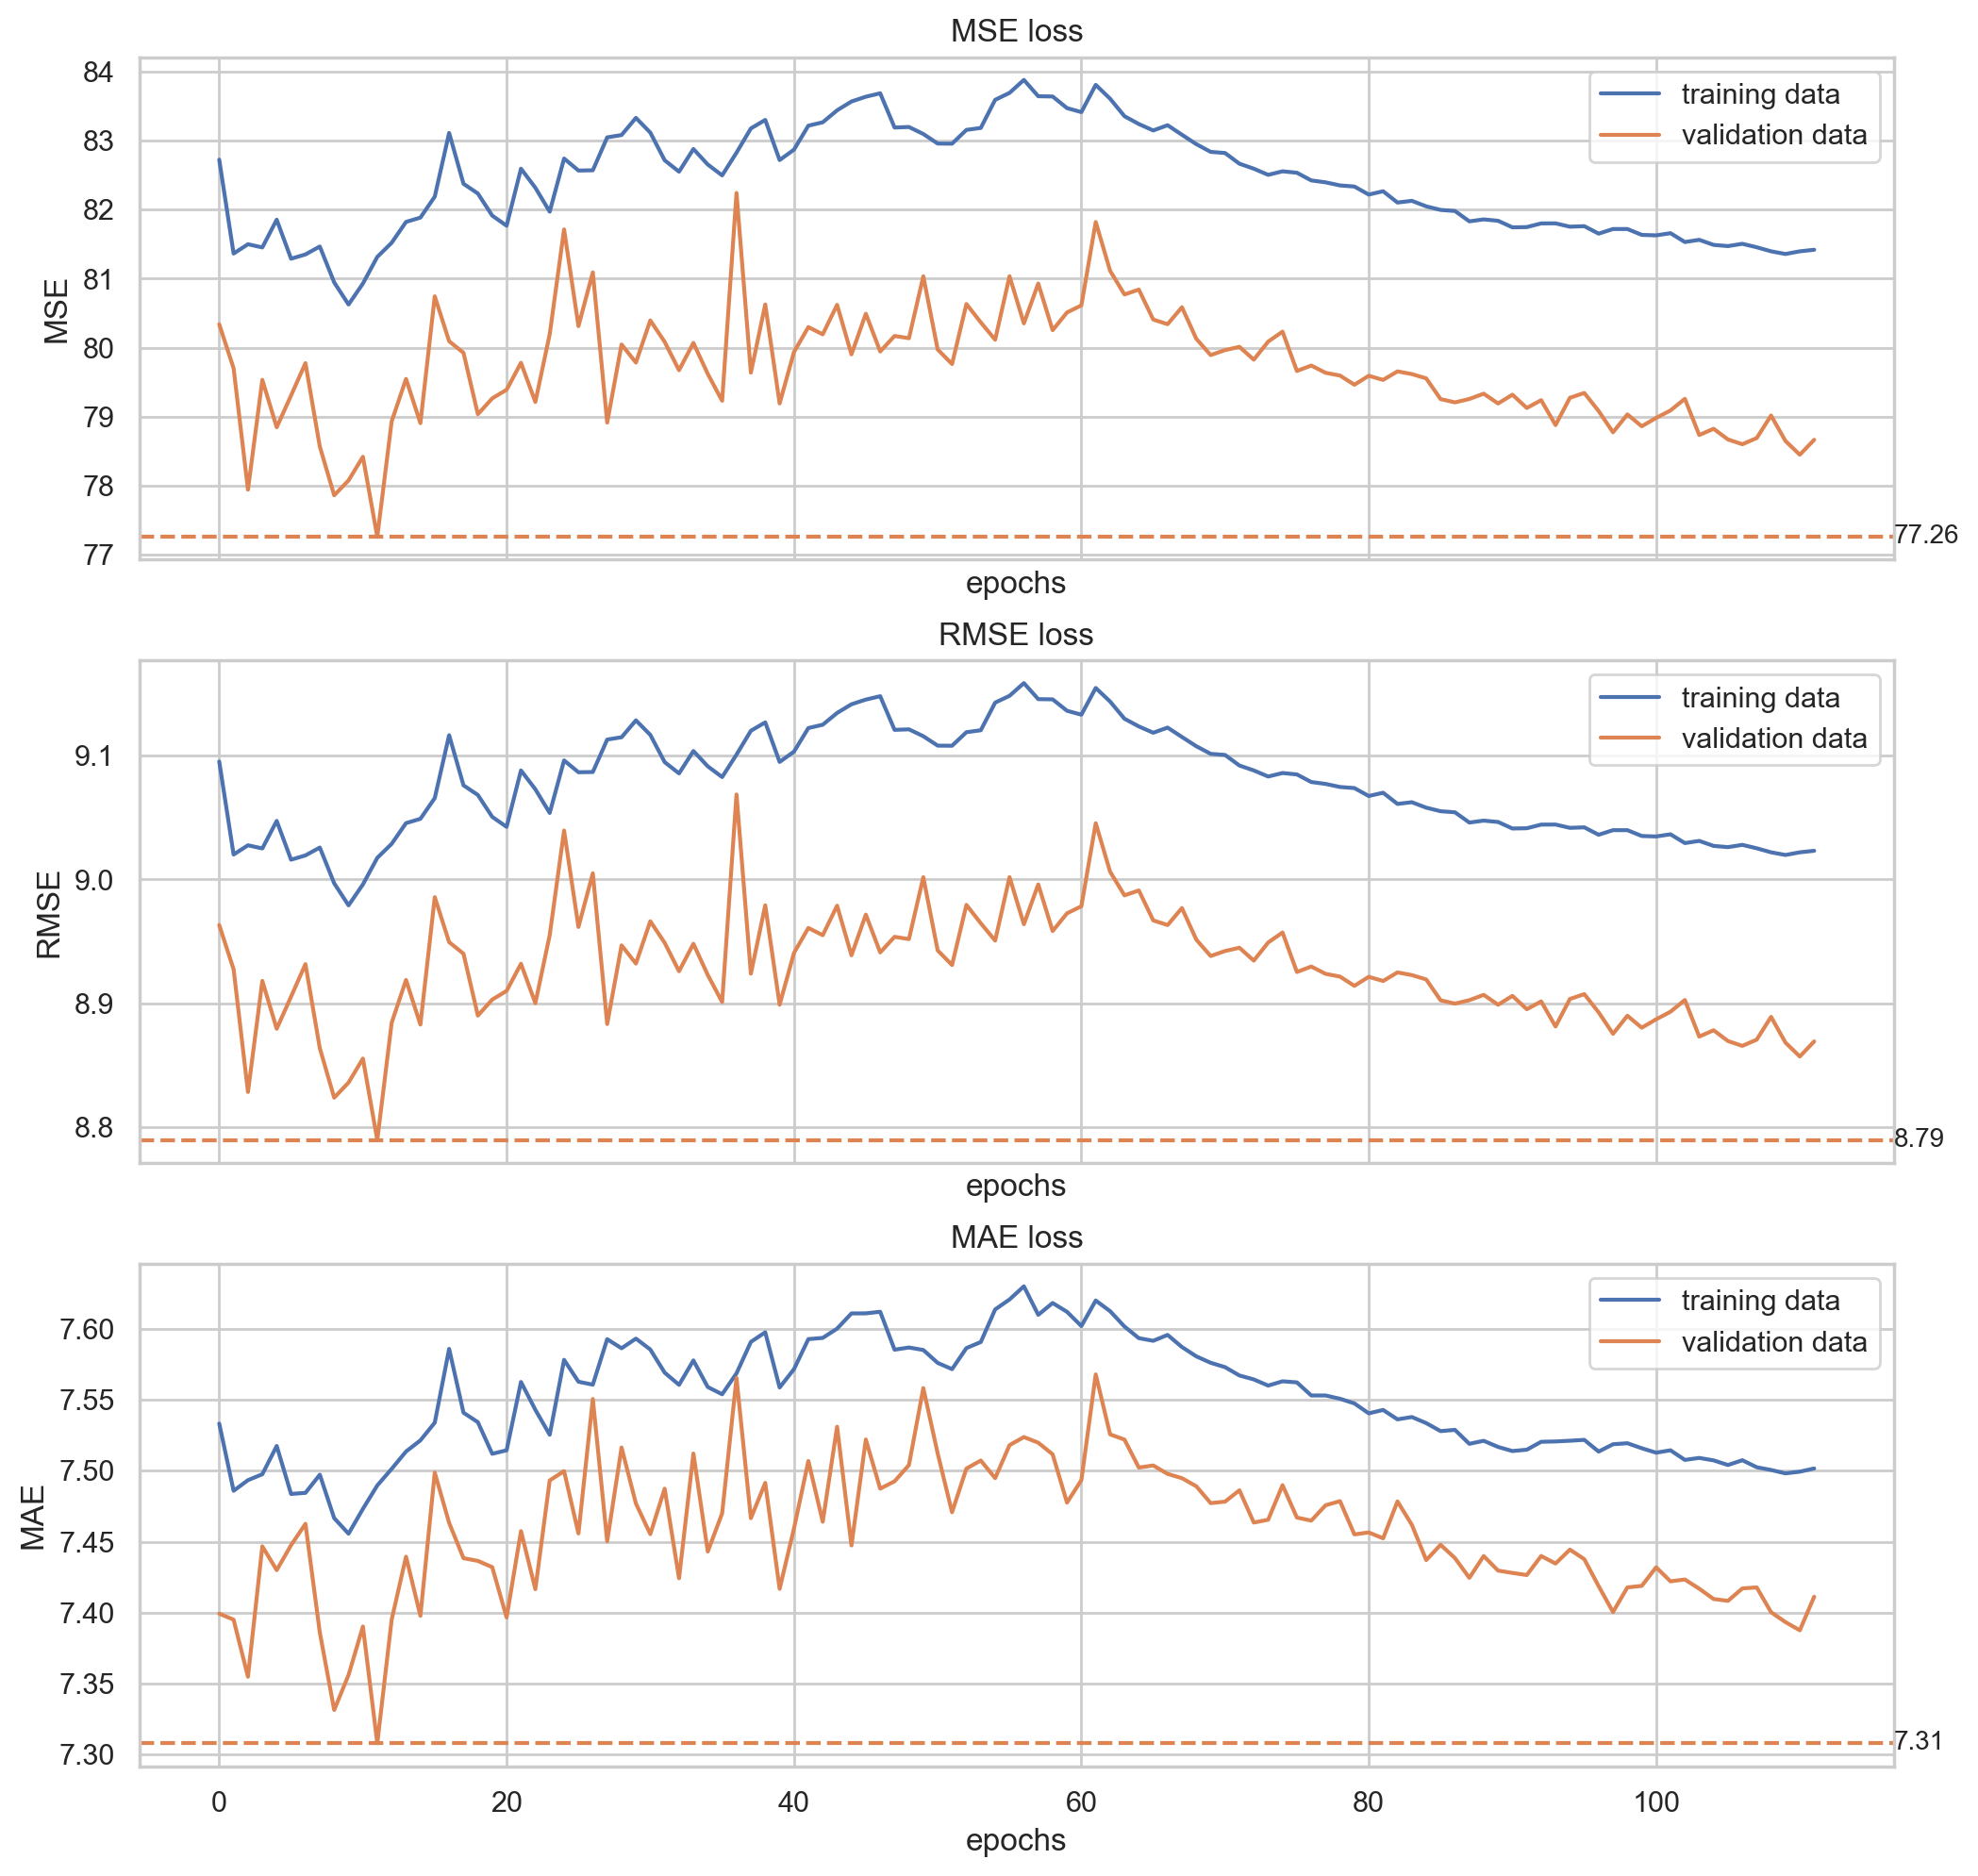

In [56]:
plot_loss(history)

In [57]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

filename = os.path.join(PATH_MODELS, 'FC_regressor_01')
model = tf.keras.models.load_model(filename + ".hdf5")

# MSE
predictions = model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
mae = mean_absolute_error(y_test, predictions)

print(f"Performance of simple FC neural network regressor: RMSE = {rmse} and MAE = {mae}.")

Performance of simple FC neural network regressor: RMSE = 8.962693403865986 and MAE = 7.322791660524111.


- Performance of 'FC_regressor_01': RMSE = 8.962693403865986 and MAE = 7.322791660524111. (Correct split)
- Performance of 'FC_regressor_02': RMSE = 8.89461832846391 and MAE = 7.288057913338504.
- Performance of 'FC_regressor_03': RMSE = 8.797764719465878 and MAE = 7.173652581160049.
- Performance of 'FC_regressor_04': RMSE = 8.918336755212458 and MAE = 7.307624677486689.
- Performance of 'FC_regressor_05': RMSE = 9.311148584537879 and MAE = 7.681811556401662.

### 'FC_regressor_06' (Fawaz et al. copy)

In [ ]:
def fully_connected_model():
        """ Returns the fully connected model from Ismail Fawaz et al. (2019). """

        input_layer = keras.layers.Input(input_shape)

        input_layer_flattened = keras.layers.Flatten()(input_layer)

        layer_1 = keras.layers.Dropout(0.1)(input_layer_flattened)
        layer_1 = keras.layers.Dense(500, activation='relu')(layer_1)

        layer_2 = keras.layers.Dropout(0.2)(layer_1)
        layer_2 = keras.layers.Dense(500, activation='relu')(layer_2)

        layer_3 = keras.layers.Dropout(0.2)(layer_2)
        layer_3 = keras.layers.Dense(500, activation='relu')(layer_3)

        output_layer = keras.layers.Dropout(0.3)(layer_3)
        output_layer = keras.layers.Dense(1)(output_layer)

        model = keras.models.Model(inputs=input_layer, outputs=output_layer)

        return model

model = fully_connected_model()

optimizer = Adadelta(learning_rate=0.01)    

model.compile(loss='mean_squared_error', 
            optimizer=optimizer, 
            metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

output_filename = f'FC_regressor_06'
output_file = os.path.join(PATH_OUTPUT, output_filename)

checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=1000, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=200, min_lr=0.0001, verbose=1)

epochs = 5000

# fit network
history = model.fit(x=X_train,
                    y=y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    callbacks=[checkpointer, earlystopper, reduce_lr])